In [1]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from nltk.translate.bleu_score import sentence_bleu
from torch.utils.data import Dataset
from typing import Iterable, List
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

##### Code built with the help of: https://pytorch.org/tutorials/beginner/translation_transformer.html

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/imdbdataset/train.csv
/kaggle/input/imdbdataset/test.csv


In [3]:
FOLDER_PATH = '/kaggle/input/imdbdataset/'

# Load Data

In [4]:
class IMDBDataset(Dataset):

    def __init__(self, filename, sentiment) -> None:
        super().__init__()
        data_df = pd.read_csv(filename)
        data_df['sentiment'] = data_df['sentiment'].apply(lambda x: 2 if x == 'pos' else 1)
        data_df['pair'] = list(zip(data_df['sentiment'], data_df['text']))

        if sentiment == 'pos':
            self.data = data_df['pair'][data_df['sentiment'] == 2].values.tolist()
        else:
            self.data = data_df['pair'][data_df['sentiment'] == 1].values.tolist()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [5]:
SENTIMENT_POS = 'pos'
SENTIMENT_NEG = 'neg'

tokenizer = get_tokenizer('basic_english')
vocab_transform = {}

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

##### POSITIVE SENTIMENT VOCAB #####
train_iter_pos = IMDBDataset(f'{FOLDER_PATH}train.csv', SENTIMENT_POS)
vocab_transform[SENTIMENT_POS] = build_vocab_from_iterator(yield_tokens(train_iter_pos),
                                                min_freq=1,
                                                specials=special_symbols,
                                                special_first=True)
vocab_transform[SENTIMENT_POS].set_default_index(UNK_IDX)

##### NEGATIVE SENTIMENT VOCAB #####
train_iter_neg = IMDBDataset(f'{FOLDER_PATH}test.csv', SENTIMENT_NEG)
vocab_transform[SENTIMENT_NEG] = build_vocab_from_iterator(yield_tokens(train_iter_neg),
                                                min_freq=1,
                                                specials=special_symbols,
                                                special_first=True)
vocab_transform[SENTIMENT_NEG].set_default_index(UNK_IDX)

In [ ]:
torch.save(vocab_transform[SENTIMENT_POS], f'{FOLDER_PATH}pos_vocab.pth')
torch.save(vocab_transform[SENTIMENT_NEG], f'{FOLDER_PATH}neg_vocab.pth')
vocab_transform

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [8]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [9]:
torch.manual_seed(0)

POS_VOCAB_SIZE = len(vocab_transform[SENTIMENT_POS])
NEG_VOCAB_SIZE = len(vocab_transform[SENTIMENT_NEG])
EMB_SIZE = 128
NHEAD = 8
FFN_HID_DIM = 128
BATCH_SIZE = 2
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2

G_NEG_to_POS = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, NEG_VOCAB_SIZE, POS_VOCAB_SIZE, FFN_HID_DIM)
G_POS_to_NEG = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, POS_VOCAB_SIZE, NEG_VOCAB_SIZE, FFN_HID_DIM)

for p in G_NEG_to_POS.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

for p in G_POS_to_NEG.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

#G_NEG_to_POS = G_NEG_to_POS.to(DEVICE)
G_POS_to_NEG = G_POS_to_NEG.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer_neg_to_pos = torch.optim.Adam(G_NEG_to_POS.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
optimizer_pos_to_neg = torch.optim.Adam(G_POS_to_NEG.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [10]:
pytorch_total_params = sum(p.numel() for p in G_NEG_to_POS.parameters() if p.requires_grad)
pytorch_total_params

27058632

In [11]:
pytorch_total_params = sum(p.numel() for p in G_POS_to_NEG.parameters() if p.requires_grad)
pytorch_total_params

26797020

In [12]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SENTIMENT_POS, SENTIMENT_NEG]:
    text_transform[ln] = sequential_transforms(tokenizer, #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    text_batch = []
    for label, text in batch:
        if label == 1:
            text_batch.append(text_transform[SENTIMENT_NEG](text.rstrip("\n")))
        else:
            text_batch.append(text_transform[SENTIMENT_POS](text.rstrip("\n")))

    text_batch = pad_sequence(text_batch, padding_value=PAD_IDX)
    return text_batch

In [13]:
def train_epoch(model, optimizer, transfer_direction):
    model.train()
    losses = 0
    train_iter_pos = IMDBDataset(f'{FOLDER_PATH}train.csv', SENTIMENT_POS)
    train_iter_neg = IMDBDataset(f'{FOLDER_PATH}train.csv', SENTIMENT_NEG)
    train_pos_dataloader = DataLoader(train_iter_pos, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    train_neg_dataloader = DataLoader(train_iter_neg, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    if transfer_direction == 'neg_to_pos':
        loop = zip(train_neg_dataloader, train_pos_dataloader)
    else:
        loop = zip(train_pos_dataloader, train_neg_dataloader)

    for src, tgt in loop:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_pos_dataloader))


def evaluate(model, transfer_direction):
    model.eval()
    losses = 0

    test_iter_pos = IMDBDataset(f'{FOLDER_PATH}test.csv', SENTIMENT_POS)
    test_iter_neg = IMDBDataset(f'{FOLDER_PATH}test.csv', SENTIMENT_NEG)
    test_pos_dataloader = DataLoader(test_iter_pos, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    test_neg_dataloader = DataLoader(test_iter_neg, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    if transfer_direction == 'neg_to_pos':
        loop = zip(test_neg_dataloader, test_pos_dataloader)
    else:
        loop = zip(test_pos_dataloader, test_neg_dataloader)
    
    for src, tgt in loop:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(test_pos_dataloader))

In [14]:
from timeit import default_timer as timer
NUM_EPOCHS = 10
train_losses = []
test_losses = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(G_POS_to_NEG, optimizer_pos_to_neg, 'pos_to_neg')
    train_losses.append(train_loss)
    end_time = timer()
    test_loss = evaluate(G_POS_to_NEG, 'pos_to_neg')
    test_losses.append(test_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Test loss: {test_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

def transfer(model: torch.nn.Module, src_sentence: str, transfer_direction: str):
    model.eval()
    if transfer_direction == 'neg_to_pos':
        src = text_transform[SENTIMENT_NEG](src_sentence).view(-1, 1)
        num_tokens = src.shape[0]
        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
        tgt_tokens = greedy_decode(
            model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
        return " ".join(vocab_transform[SENTIMENT_POS].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")
    else:
        src = text_transform[SENTIMENT_POS](src_sentence).view(-1, 1)
        num_tokens = src.shape[0]
        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
        tgt_tokens = greedy_decode(
            model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
        return " ".join(vocab_transform[SENTIMENT_NEG].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

Epoch: 1, Train loss: 6.092, Test loss: 5.806, Epoch time = 286.487s
Epoch: 2, Train loss: 5.550, Test loss: 5.708, Epoch time = 285.916s
Epoch: 3, Train loss: 5.410, Test loss: 5.652, Epoch time = 285.834s
Epoch: 4, Train loss: 5.313, Test loss: 5.670, Epoch time = 285.743s
Epoch: 5, Train loss: 5.238, Test loss: 5.615, Epoch time = 285.408s
Epoch: 6, Train loss: 5.179, Test loss: 5.596, Epoch time = 285.412s
Epoch: 7, Train loss: 5.131, Test loss: 5.601, Epoch time = 285.286s
Epoch: 8, Train loss: 5.091, Test loss: 5.575, Epoch time = 285.064s
Epoch: 9, Train loss: 5.056, Test loss: 5.567, Epoch time = 285.674s
Epoch: 10, Train loss: 5.025, Test loss: 5.502, Epoch time = 284.924s


In [ ]:
plt.plot(range(NUM_EPOCHS), train_losses, label='Train Losses')
plt.plot(range(NUM_EPOCHS), test_losses, label='Test Losses')
plt.title('Training and Testing Loss by Epoch For Negative to Positive Generator')
plt.show()
plt.savefig(f'/kaggle/working/negative_to_positive_losses.png')

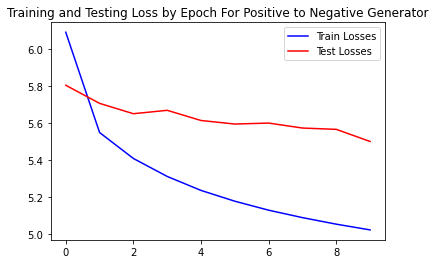

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(range(NUM_EPOCHS), train_losses, 'b-')
plt.plot(range(NUM_EPOCHS), test_losses, 'r-')
plt.title('Training and Testing Loss by Epoch For Positive to Negative Generator')
plt.legend(['Train Losses', 'Test Losses'])
plt.show()
plt.savefig(f'/kaggle/working/positive_to_negative_losses.png')

In [ ]:
test_iter_pos = IMDBDataset(f'{FOLDER_PATH}test.csv', SENTIMENT_POS)
test_iter_neg = IMDBDataset(f'{FOLDER_PATH}test.csv', SENTIMENT_NEG)

avg_bleu_1_score = 0
pbar = tqdm(total=len(test_iter_pos))
for pos, neg in zip(test_iter_pos, test_iter_neg):
  pos_out = transfer(G_NEG_to_POS, neg[1][0], 'neg_to_pos')
  avg_bleu_1_score += sentence_bleu(pos[1][0].split(' '), pos_out.split(' '), weights=[1, 0, 0, 0])
  pbar.update(1)

pbar.close()
avg_bleu_1_score /= len(test_iter_pos)

In [ ]:
avg_bleu_1_score

In [17]:
test_iter_pos = IMDBDataset(f'{FOLDER_PATH}test.csv', SENTIMENT_POS)
test_iter_neg = IMDBDataset(f'{FOLDER_PATH}test.csv', SENTIMENT_NEG)

avg_bleu_1_score = 0
pbar = tqdm(total=len(test_iter_pos))
for pos, neg in zip(test_iter_pos, test_iter_neg):
  neg_out = transfer(G_POS_to_NEG, pos[1][0], 'pos_to_neg')
  avg_bleu_1_score += sentence_bleu(neg[1][0].split(' '), neg_out.split(' '), weights=[1, 0, 0, 0])
  pbar.update(1)

pbar.close()
avg_bleu_1_score /= len(test_iter_pos)


  0%|          | 0/12500 [00:37<?, ?it/s]

  1%|▏         | 164/12500 [00:03<04:20, 47.39it/s]/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order

In [18]:
avg_bleu_1_score

0.000992857142857143

In [ ]:
print(transfer(G_NEG_to_POS, "This movie sucks.", 'neg_to_pos'))

In [ ]:
torch.save(G_NEG_to_POS.state_dict(), f'{FOLDER_PATH}G_NEG_to_POS.pkl')

In [20]:
print(transfer(G_POS_to_NEG, "This movie is great.", 'pos_to_neg'))

 i was a fan of the worst movies i ' ve


In [22]:
torch.save(G_POS_to_NEG.state_dict(), f'/kaggle/working/G_POS_TO_NEG.pkl')